<a href="https://colab.research.google.com/github/sillsphelyx/Geospatial-Analysis/blob/main/Trend_Analysis_KwaDlangezwa_Khandisa_Farmland_and_Building_total_Areas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter, YearLocator
import pymc as pm
import arviz as az

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Monthly_mean_results.csv to Monthly_mean_results.csv


In [3]:
from google.colab import drive
drive.mount('/content/drive')
#Insert the directoryimport sys
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Geo-Spatial-Analysis')

Mounted at /content/drive


In [4]:
# Replace 'your_file.csv' with the actual name of your file
df = pd.read_csv('Monthly_mean_results.csv', delimiter= ',', skipinitialspace=True)
# Display the first few rows to understand the structure
print(df.head())

         Date  Farmland Area (km²)  Built-up Area (km²)
0  2017-06-30             8.861939             7.337939
1  2017-07-31             8.799685             7.400193
2  2017-08-31             8.331994             7.867884
3  2017-09-30             8.148728             8.051150
4  2017-10-31             8.116492             8.083386


In [5]:
# Data Interpolation
from scipy.interpolate import interp1d
import numpy as np

# Replace 'mydata' with 'df' to use the DataFrame that was loaded from the CSV
for col in ['Farmland Area (km²)', 'Built-up Area (km²)']:
    non_na_data = df.dropna(subset=[col])  # Use 'df' instead of 'mydata'
    # Convert index to numeric type before interpolation
    numeric_index = pd.to_numeric(non_na_data.index, errors='coerce')
    # Remove rows with invalid numeric index values (NaNs introduced by errors='coerce')
    non_na_data = non_na_data[~np.isnan(numeric_index)]
    numeric_index = numeric_index[~np.isnan(numeric_index)]
    f = interp1d(numeric_index, non_na_data[col], kind='cubic', fill_value="extrapolate")
    df[col] = f(np.arange(len(df)))  # Use 'df' instead of 'mydata'

In [6]:
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)
df.head()

,Farmland Area (km²),Built-up Area (km²)
Date,,
2017-06-30,8.861939,7.337939
2017-07-31,8.799685,7.400193
2017-08-31,8.331994,7.867884
2017-09-30,8.148728,8.051150
2017-10-31,8.116492,8.083386


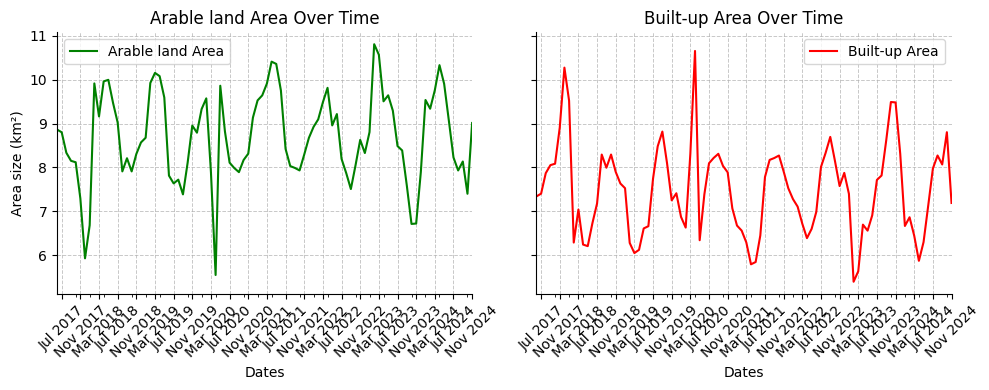

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and it has the necessary columns
# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot Farmland Area and Built-up Area in the first subplot
df['Farmland Area (km²)'].plot(kind='line', ax=axes[0], color='green', label='Arable land Area')
axes[0].set_title('Arable land Area Over Time')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Area size (km²)')
# Set x-axis ticks for the first subplot
ticks = pd.date_range(start=df.index.min(), end=df.index.max(), freq='4MS')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticks.strftime('%b %Y'), rotation=45)
axes[0].legend()
axes[0].grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
axes[0].spines[['top', 'right']].set_visible(False)

# Plot Built-up Area in the second subplot
df['Built-up Area (km²)'].plot(kind='line', ax=axes[1], color='red', label='Built-up Area')
axes[1].set_title('Built-up Area Over Time')
axes[1].set_xlabel('Dates')
# Set x-axis ticks for the second subplot
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(ticks.strftime('%b %Y'), rotation=45)
axes[1].legend()
axes[1].grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
axes[1].spines[['top', 'right']].set_visible(False)

# Adjust layout to ensure proper spacing
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/UZ_Classified_images/Arable_built_TS_sep.png", dpi=300, bbox_inches="tight")
# Show the plots
plt.show()



#Bayesian Trend Analysis

Output()

Output()

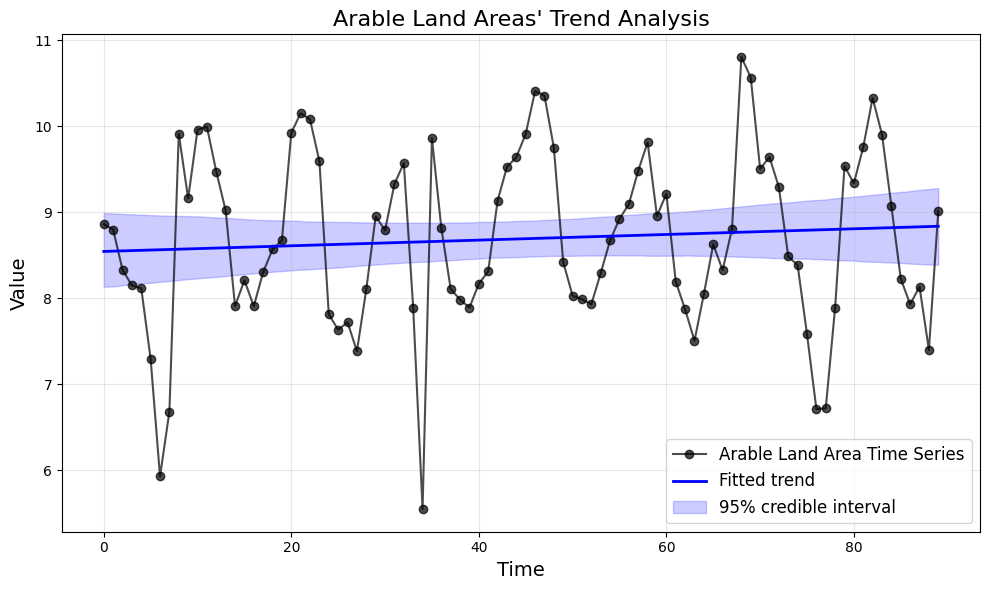

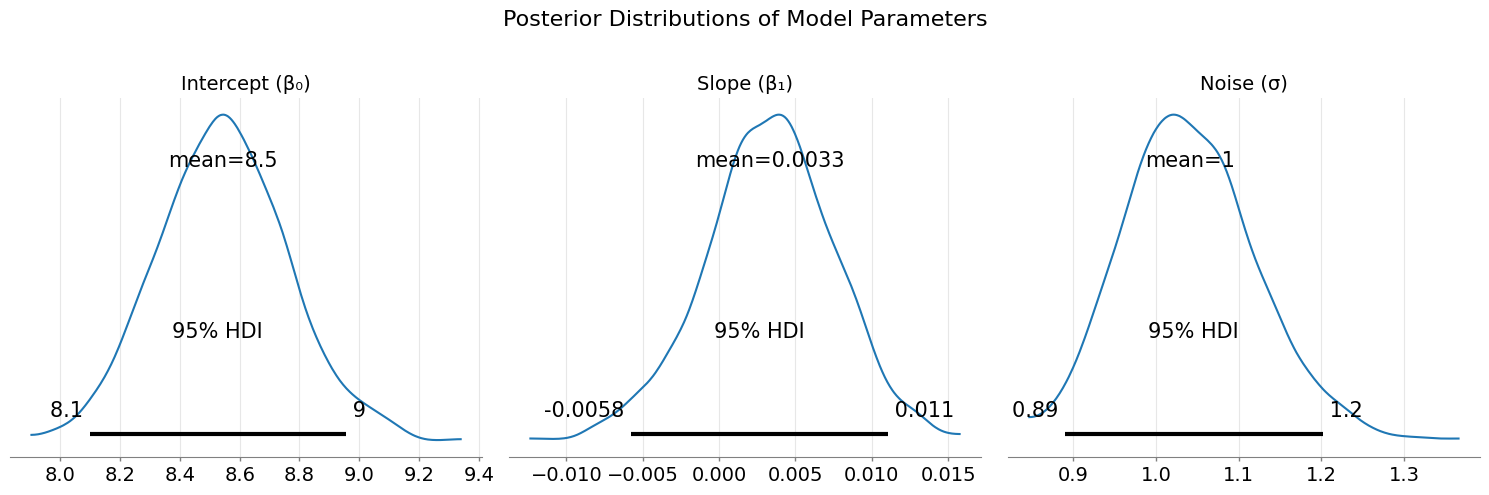

In [ ]:
# Simulate data
np.random.seed(42)
true_beta_0 = 2
true_beta_1 = 0.5
true_sigma = 1
# Replace with actual data
# y = true_beta_0 + true_beta_1 * t + np.random.normal(0, true_sigma, size=100)
y = df['Farmland Area (km²)'].values
t = np.arange(len(y))

# Bayesian model
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Likelihood
    mu = beta_0 + beta_1 * t
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True)

# Extract posterior samples
posterior_samples = az.extract(trace, group="posterior")

# Compute fitted line and confidence bands
t_pred = np.linspace(t.min(), t.max(), 200)  # Finer grid for smoother plot
posterior_beta_0 = posterior_samples["beta_0"].values.reshape(-1, 1)
posterior_beta_1 = posterior_samples["beta_1"].values.reshape(-1, 1)
posterior_pred = posterior_beta_0 + posterior_beta_1 * t_pred

mean_pred = np.mean(posterior_pred, axis=0)
lower_bound = np.percentile(posterior_pred, 2.5, axis=0)
upper_bound = np.percentile(posterior_pred, 97.5, axis=0)

# Plot time series with fitted trend and confidence bands
plt.figure(figsize=(10, 6))
plt.plot(t, y, marker="o", linestyle="-", color="black", alpha=0.7, label="Arable Land Area Time Series")
plt.plot(t_pred, mean_pred, color="blue", label="Fitted trend", linewidth=2)
plt.fill_between(t_pred, lower_bound, upper_bound, color="blue", alpha=0.2, label="95% credible interval")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("Arable Land Areas' Trend Analysis", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot posterior distributions for parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
az.plot_posterior(trace, var_names=["beta_0"], hdi_prob=0.95, ax=axes[0])
az.plot_posterior(trace, var_names=["beta_1"], hdi_prob=0.95, ax=axes[1])
az.plot_posterior(trace, var_names=["sigma"], hdi_prob=0.95, ax=axes[2])

# Customize plot aesthetics
for ax, var in zip(axes, ["Intercept (β₀)", "Slope (β₁)", "Noise (σ)"]):
    ax.set_title(var, fontsize=14)
    ax.grid(alpha=0.3)
plt.suptitle("Posterior Distributions of Model Parameters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Output()

Output()

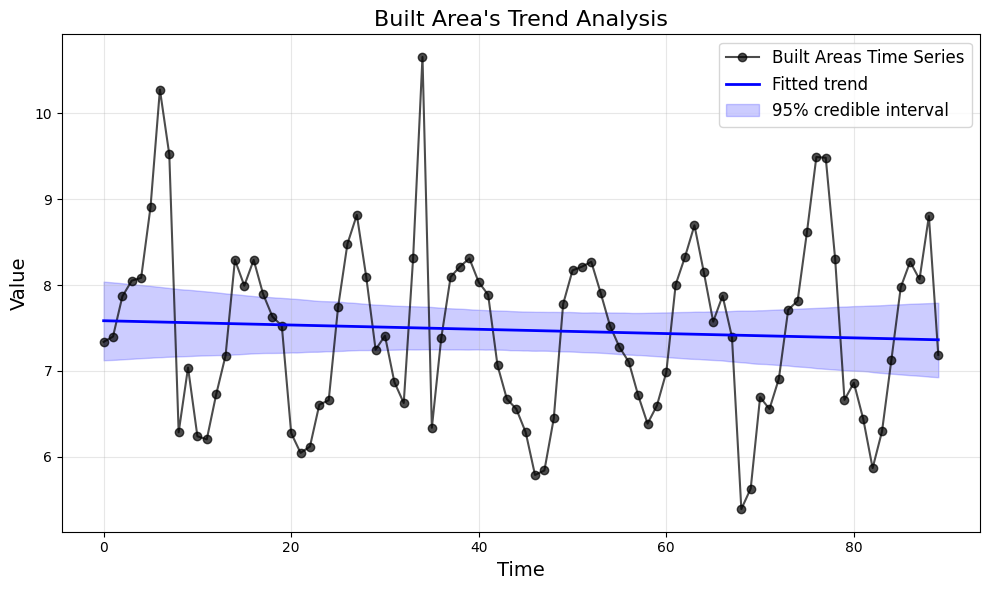

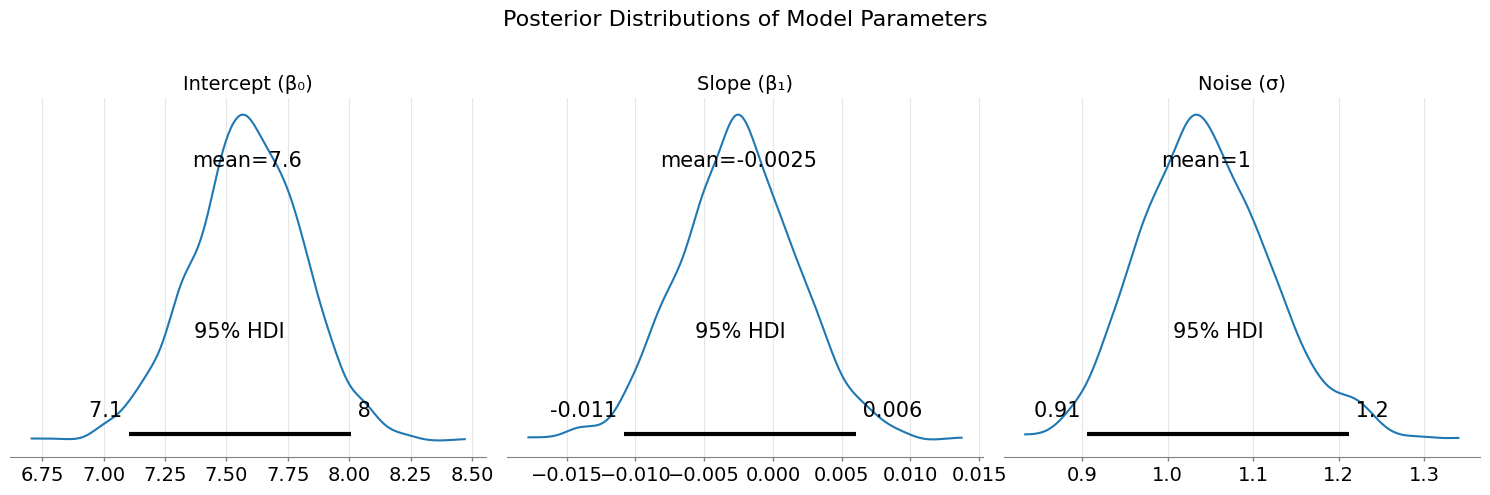

In [ ]:
#Built up Area

# Simulate data
np.random.seed(42)
true_beta_0 = 2
true_beta_1 = 0.5
true_sigma = 1
# Replace with actual data
# y = true_beta_0 + true_beta_1 * t + np.random.normal(0, true_sigma, size=100)
y = df['Built-up Area (km²)'].values
t = np.arange(len(y))

# Bayesian model
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Likelihood
    mu = beta_0 + beta_1 * t
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True)

# Extract posterior samples
posterior_samples = az.extract(trace, group="posterior")

# Compute fitted line and confidence bands
t_pred = np.linspace(t.min(), t.max(), 200)  # Finer grid for smoother plot
posterior_beta_0 = posterior_samples["beta_0"].values.reshape(-1, 1)
posterior_beta_1 = posterior_samples["beta_1"].values.reshape(-1, 1)
posterior_pred = posterior_beta_0 + posterior_beta_1 * t_pred

mean_pred = np.mean(posterior_pred, axis=0)
lower_bound = np.percentile(posterior_pred, 2.5, axis=0)
upper_bound = np.percentile(posterior_pred, 97.5, axis=0)

# Plot time series with fitted trend and confidence bands
plt.figure(figsize=(10, 6))
plt.plot(t, y, marker="o", linestyle="-", color="black", alpha=0.7, label="Built Areas Time Series")
plt.plot(t_pred, mean_pred, color="blue", label="Fitted trend", linewidth=2)
plt.fill_between(t_pred, lower_bound, upper_bound, color="blue", alpha=0.2, label="95% credible interval")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("Built Area's Trend Analysis", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot posterior distributions for parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
az.plot_posterior(trace, var_names=["beta_0"], hdi_prob=0.95, ax=axes[0])
az.plot_posterior(trace, var_names=["beta_1"], hdi_prob=0.95, ax=axes[1])
az.plot_posterior(trace, var_names=["sigma"], hdi_prob=0.95, ax=axes[2])

# Customize plot aesthetics
for ax, var in zip(axes, ["Intercept (β₀)", "Slope (β₁)", "Noise (σ)"]):
    ax.set_title(var, fontsize=14)
    ax.grid(alpha=0.3)
plt.suptitle("Posterior Distributions of Model Parameters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
